## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

I have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. I will make following preprocessing:
1. I will scale all images to resolution $100 \times 100$ pixels.
2. I will scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
import os
import urllib.request
urllib.request.urlretrieve('https://d3c33hcgiwev3.cloudfront.net/LcTgxTW1EeinvxKfGmYdOg_2e58bbc035b511e898cbad3617519b35_facial-keypoints.zip?Expires=1591228800&Signature=F-pYRqpsCVLq7cxwabN71Dxrv3SmF6Lhkx9lvn0yQj-xuO97Dq6jgUkXgYreTkd1ZOdGj21-IZRdH9na1-3BtPibcIE1H5lYvTg4dk0OBMir8JLG8s-bOByLc9TuMoPI-Av2Sr40LubZugjM54wqXtPafLq7~WqRNMzFotte5Mg_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A', 'data')

('data', <http.client.HTTPMessage at 0x7fa3b2200ef0>)

In [0]:
import zipfile
with zipfile.ZipFile("data","r") as zip_ref:
    zip_ref.extractall("targetdir")

In [8]:
import pandas as pd 
from skimage.io import imread
from numpy import array, zeros
import numpy as np
from skimage.io import imshow
from skimage.transform import resize
import os 

def load_imgs_and_keypoints(dirname='facial-keypoints'):


    points = pd.read_csv('targetdir/facial-keypoints/data/gt.csv',sep=",")
    points = points.to_numpy()
    points = points[:,1:]


    file_names = os.listdir('targetdir/facial-keypoints/data/images/')  
    file_names.sort()
    imgs = []


    id_img=0
   
    for img_name in file_names:
        if id_img%500==0:
            print(img_name)
        image =  imread('targetdir/facial-keypoints/data/images/'+img_name)
        
        for i in range(0,28):
            
            if i%2 ==0:
                points[id_img,i]=(points[id_img,i]/image.shape[0])-0.5
            else:
                points[id_img,i]=(points[id_img,i]/image.shape[1])-0.5


        id_img=id_img+1
        
        image =  resize(image,(100,100,3))
        imgs.append(image)  

    im  = array(imgs)

    return im,points

imgs, points = load_imgs_and_keypoints()
print(imgs.shape)
print(imgs.shape)

00000.jpg
00500.jpg
01000.jpg
01500.jpg
02000.jpg
02500.jpg
03000.jpg
03500.jpg
04000.jpg
04500.jpg
05000.jpg
05500.jpg
(6000, 100, 100, 3)
(6000, 100, 100, 3)


array([-0.2765957446808511, -0.2872340425531915, -0.11702127659574468,
       -0.30851063829787234, 0.1063829787234043, -0.2978723404255319,
       0.35106382978723405, -0.23404255319148937, -0.25531914893617025,
       -0.21276595744680848, -0.1382978723404255, -0.22340425531914893,
       -0.07446808510638298, -0.2021276595744681, 0.12765957446808507,
       -0.18085106382978722, 0.22340425531914898, -0.18085106382978722,
       0.32978723404255317, -0.14893617021276595, -0.04255319148936171,
       -0.010638297872340441, -0.17021276595744683, 0.14893617021276595,
       -0.021276595744680826, 0.2021276595744681, 0.13829787234042556,
       0.19148936170212771], dtype=object)

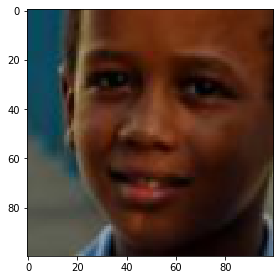

In [9]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[1])
points[1]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

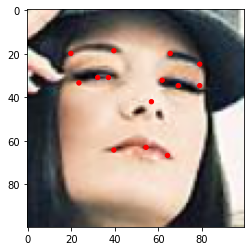

In [10]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig,ax= plt.subplots(1)
    ax.imshow(img)
    
    for i in range(0,27,2):
        x,y = (points[i]+0.5)*100,(points[i+1]+0.5)*100
        circ = Circle((x,y),1,color="r")
        ax.add_patch(circ)
        
        
    
plt.show()
    
visualize_points(imgs[8], points[8])

### Train/val split

10% for validation data

In [11]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)
type(imgs_train)

numpy.ndarray

### Simple data augmentation

For better training i will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face).

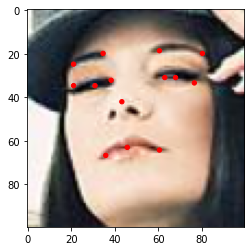

In [12]:
def flip_img(img, p):
    # Write your code for flipping here
        
    img = np.fliplr(img)            
    
    k=np.copy(p)
    
    for i in range(0,27,2):
        
        k[i]=k[i]*(-1)

    
    return img,k

    

f_img, f_points = flip_img(imgs[8], points[8])
visualize_points(f_img, f_points)

Time to augment our training sample.I will apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:
# Write your code here
aug_imgs_train = []
aug_points_train = []
    
for i in range(points_train.shape[0]):
        
        fli_img, fli_points = flip_img(imgs_train[i], points_train[i])
        aug_imgs_train.append(fli_img)
        aug_points_train.append(fli_points)
    
        
        aug_imgs_train.append(imgs_train[i])
        aug_points_train.append(points_train[i]) 


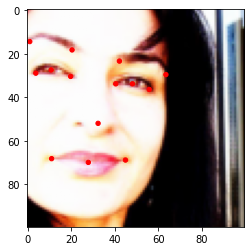

In [67]:
visualize_points(aug_imgs_train[101], aug_points_train[101])

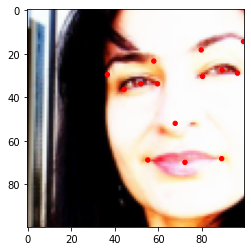

In [66]:
visualize_points(aug_imgs_train[100], aug_points_train[100])

### Network architecture and training




In [0]:
from  tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,  Dense, Dropout,BatchNormalization

In [0]:
model = Sequential()
# Define here your model
model.add(Conv2D(16,(3,3),input_shape=[100,100,3],kernel_initializer="he_uniform",activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),kernel_initializer="he_uniform",activation="relu",padding="same"))

model.add(MaxPooling2D((2,2)))


model.add(Conv2D(64,(3,3),kernel_initializer="he_uniform",activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),kernel_initializer="he_uniform",activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256,(3,3),kernel_initializer="he_uniform",activation="relu",padding="same"))
model.add(MaxPooling2D((2,2)))


model.add(Flatten())
model.add(Dense(500,kernel_initializer="he_uniform",activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(500,kernel_initializer="he_uniform",activation="relu"))
model.add(Dense(28))


Time to train! Since wekerasre training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [48]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

# Choose optimizer, compile model and run training
model.compile(loss="mse",optimizer="adam",metrics=['mean_squared_error'])

aug_imgs_train = np.stack(aug_imgs_train, axis=0)
aug_imgs_train = tf.convert_to_tensor(aug_imgs_train, dtype=tf.float32)

aug_points_train = np.stack(aug_points_train, axis=0)
aug_points_train = tf.convert_to_tensor(aug_points_train, dtype=tf.float32)

imgs_val = np.stack(imgs_val, axis=0)
imgs_val = tf.convert_to_tensor(imgs_val, dtype=tf.float32)

points_val = np.stack(points_val, axis=0)
points_val = tf.convert_to_tensor(points_val, dtype=tf.float32)



print(aug_imgs_train.shape)
history = model.fit(aug_imgs_train,aug_points_train,epochs=100,validation_data=(imgs_val,points_val),
                                                                              callbacks=[checkpoint])

(10800, 100, 100, 3)
Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 00001: val_loss improved from inf to 0.01719, saving model to weights.hdf5
338/338 [==============================] - 3s 9ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0172 - val_mean_squared_error: 0.0172
Epoch 2/100
333/338 [============================>.] - ETA: 0s - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 00002: val_loss improved from 0.01719 to 0.01615, saving model to weights.hdf5
338/338 [==============================] - 3s 8ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 3/100
332/338 [============================>.] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 00003: val_loss did not improve from 0.01615
338/338 [==============================] - 3s 8ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0195 - val_mean_squared_er

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

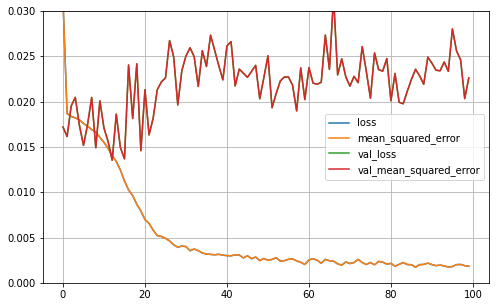

In [49]:
import pandas as pd 
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.03)
plt.show()

<h2>prediction</h2>

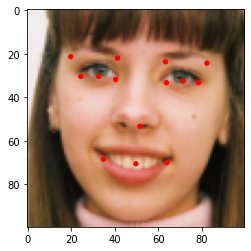

In [62]:
p_pred=model.predict(imgs_val)
visualize_points(imgs_val[1],p_pred[1])


<h2>Ground truth</h2>


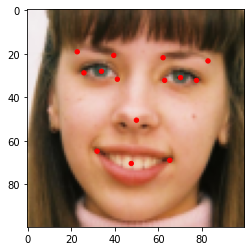

In [63]:
visualize_points(imgs_val[1],points_val[1])